In [9]:
import pandas as pd
import numpy as np 
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
from torchsummary import summary
from torch.autograd import Variable

In [10]:
# Read the data
import glob,os
path=r'../Dataset/'
file=glob.glob(os.path.join(path, "data*.csv"))
print(file)
dl= []
for f in file:
 dl.append(pd.read_csv(f,header=[0],index_col=None))
df=pd.concat(dl)

['../Dataset\\data1.csv', '../Dataset\\data10.csv', '../Dataset\\data11.csv', '../Dataset\\data12.csv', '../Dataset\\data13.csv', '../Dataset\\data14.csv', '../Dataset\\data15.csv', '../Dataset\\data2.csv', '../Dataset\\data3.csv', '../Dataset\\data4.csv', '../Dataset\\data5.csv', '../Dataset\\data6.csv', '../Dataset\\data7.csv', '../Dataset\\data8.csv', '../Dataset\\data9.csv']


In [116]:
# label Encoding
df['marker'] = df['marker'].replace(['Natural'],0)
df['marker'] = df['marker'].replace(['Attack'],1)
df['marker'].value_counts()

1    55663
0    22714
Name: marker, dtype: int64

In [117]:
# Separate target from predictors
y = df.marker
x = df.drop(['marker'], axis=1)

In [118]:
values = x
# np.all(np.isfinite(values))
values.replace([np.inf, -np.inf], np.nan, inplace=True)

In [119]:
#normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_normalized=scaler.fit_transform(x)
X_normalized

array([[0.6955546 , 0.84220973, 0.36229508, ..., 0.        , 0.        ,
        0.        ],
       [0.70469051, 0.85941118, 0.3713831 , ..., 0.        , 0.        ,
        0.        ],
       [0.70481784, 0.85957658, 0.37151042, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.33600726, 0.86470394, 0.00275346, ..., 0.        , 0.        ,
        0.        ],
       [0.33587993, 0.86486934, 0.00262613, ..., 0.        , 0.        ,
        0.        ],
       [0.33552977, 0.86520013, 0.0022919 , ..., 0.        , 0.        ,
        0.        ]])

In [120]:
from sklearn.model_selection import train_test_split
# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_normalized, y, train_size=0.1, test_size=0.1,
                                                                random_state=0)

In [121]:
class DNN(nn.Module):
    def __init__(self,input_size, output_size):
        super().__init__()
  
        

        self.fc1 = nn.Linear(input_size,400)
        self.fc2 = nn.Linear(400,150)
        self.fc3 = nn.Linear(150,output_size)
        self.tanh1 = nn.Tanh()
        self.tanh2 = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
     
    def forward(self, x):   
        per_out=[]
        output = self.tanh1(self.fc1(x))
        print(output.shape)
        per_out.append(output)
        output = self.tanh2(self.fc2(output))
        print(output.shape)
        per_out.append(output)
        score = self.sigmoid(self.fc3(output))
        return score, per_out

In [122]:
def evaluate_accuracy(x,y,model):
    output,pre_out = model(x)
    output = torch.reshape(output,[-1,1])
    correct = (output.ge(0.5) == y).sum().item()
    n = y.shape[0]
    return correct/n

In [123]:
input_size = 128
output_size = 1


device = torch.device('cuda')
model = DNN(input_size,output_size).to(device)
loss_function = nn.BCELoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
print(model)

DNN(
  (fc1): Linear(in_features=128, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=150, bias=True)
  (fc3): Linear(in_features=150, out_features=1, bias=True)
  (tanh1): Tanh()
  (tanh2): Tanh()
  (sigmoid): Sigmoid()
)


In [124]:
import torch.utils.data as Data
# 将输入和输出封装进Data.TensorDataset()类对象
x = torch.tensor(X_train_full[:]).float()
x = torch.where(torch.isnan(x), torch.full_like(x, 0), x)
    
y = y_train[:]
y = np.array(y)
# y = torch.tensor(np.reshape(y,[-1,1]))
y = torch.tensor(y)
y = y.float()
print(x.shape)
print(y.shape)

torch_dataset = Data.TensorDataset(x,y)

torch.Size([7837, 128])
torch.Size([7837])


In [125]:
train_dataloader = torch.utils.data.DataLoader(torch_dataset, batch_size=1, shuffle=False, num_workers=1)

In [126]:
# epochs = 200
# for epoch in range(epochs):
#   model.train()
#   for batch, (batch_x, batch_y) in enumerate(train_dataloader):
    
#     batch_x = batch_x.to(device)
   
#     output,pre_out = model(batch_x)
#     output = torch.reshape(output,[-1,1])
#     batch_y = np.array(batch_y)
#     batch_y = torch.tensor(np.reshape(batch_y,[-1,1]))
#     batch_y = batch_y.float()
#     batch_y = batch_y.to(device)
#     loss = loss_function(output,batch_y).to(device)
#     acc = evaluate_accuracy(batch_x,batch_y,model)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     if epoch % 1 == 0:
#       print("epoch:{} batch:{} loss:{} acc:{}".format(epoch,batch,loss.item(),acc))


In [127]:
len(X_train_full)

7837

In [128]:
epochs = 200
import time

time_start=time.time()
for epoch in range(epochs):
    model.train()
    x = torch.tensor(X_train_full[:]).float()
    x = torch.where(torch.isnan(x), torch.full_like(x, 0), x)
    
    y = y_train[:]
    y = np.array(y)
    y = torch.tensor(np.reshape(y,[-1,1]))
    y = y.float()
    
    x = x.cuda()
    y = y.cuda()
    output,pre_out = model(x)
    output = torch.reshape(output,[-1,1])
    loss = loss_function(output,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 5 == 0:
        print("epoch:{} loss:{}".format(epoch,loss.item()))
time_end=time.time()
print('totally cost',time_end-time_start) 

torch.Size([7837, 400])
torch.Size([7837, 150])
epoch:0 loss:0.7140213251113892
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
epoch:5 loss:0.7104658484458923
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
epoch:10 loss:0.7070251703262329
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
epoch:15 loss:0.7036952972412109
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.

torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
epoch:155 loss:0.6431038975715637
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
epoch:160 loss:0.6417797803878784
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
epoch:165 loss:0.6404969096183777
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])
torch.Size([7837, 150])
epoch:170 loss:0.6392537951469421
torch.Size([7837, 400])
torch.Size([7837, 150])
torch.Size([7837, 400])


70539 13.863641262054443
54863 11.40418791770935
39188 9.640115976333618
23513 8.214153289794922
7837  2.1043949127197266

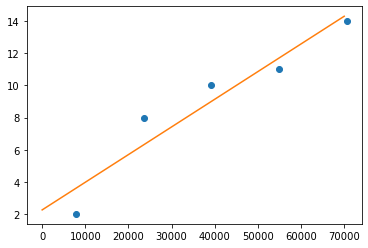

In [129]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
x = [[7837], [23512], [39187], [54863],[70538]]
y = [[2], [8], [10], [11], [14]]
reg = LinearRegression().fit(x,y)
x_pre = np.linspace(0,70000,5)
x_pre = x_pre.reshape(-1,1)
y_pre = reg.predict(x_pre)
plt.plot(x, y,'o')
plt.plot(x_pre, y_pre)
plt.show()

In [130]:
a = reg.coef_
b = reg.intercept_
print(a,b)

[[0.00017225]] [2.25016395]


In [ ]:
whole_latency = 7399.22449596
latency = 5504.72627

In [ ]:
whole_latency = 306.98
latency = 233.7